AML# AML: 05 Adversarial Example for CIFAR-10


## Data and Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, utils
import matplotlib.pyplot as plt
import numpy, random


# set the PseudoRandom Generator Seeds for better reproducibility
# see here for more: https://pytorch.org/docs/stable/notes/randomness.html
torch.manual_seed(99)
random.seed(99)
numpy.random.seed(99)

# this 'device' will be used for training our model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### **Load the CIFAR10 dataset**
Observe that we set `shuffle=True`, which means that data is randomized

In [27]:
input_size  = 32*32*3   # images are 32x32 pixels with 3 channels
output_size = 10      # there are 10 classes

mean_cifar10 = [0.485, 0.456, 0.406]   
std_cifar10 = [0.229, 0.224, 0.225]

train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                   ])),
    batch_size=128, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                   ])),
    batch_size=1ValueError: only one element tensors can be converted to Python scalarsValueError: only one element tensors can be converted to Python scalars, shuffle=True)

classNames= ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified


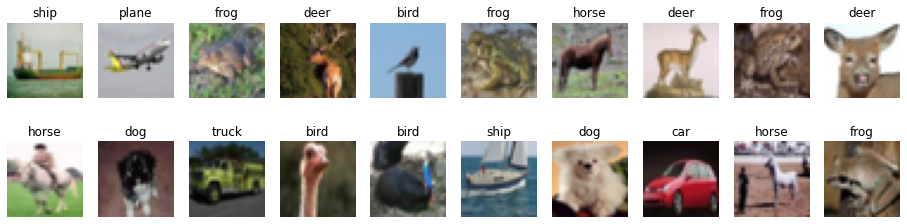

In [3]:
# show some training images
def imshow(img, plot):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()   # convert from tensor
    plot.imshow(numpy.transpose(npimg, (1, 2, 0))) 
    

plt.figure(figsize=(16,4))

# fetch a batch of train images; RANDOM
image_batch, label_batch = next(iter(train_loader))
#imshow(torchvision.utils.make_grid(image_batch))
for i in range(20):
    image = image_batch[i]
    label = classNames[label_batch[i].item()]
    plt.subplot(2, 10, i + 1)
    #image, label = train_loader.dataset.__getitem__(i)
    #plt.imshow(image.squeeze().numpy())
    imshow(image, plt)
    plt.axis('off')
    plt.title(label)
plt.show()

## CNN for CIFAR-10


### Helper functions for training and testing

In [4]:
# function to count number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

accuracy_list = []
# we pass a model object to this trainer, and it trains this model for one epoch
def train(epoch, model):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # send to device
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
def test(model):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # send to device
        data, target = data.to(device), target.to(device)
        
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))
    return accuracy

### Defining the Convolutional Neural Network

In [5]:
# FROM: https://github.com/boazbk/mltheoryseminar/blob/main/code/hw0/simple_train.ipynb
## 5-Layer CNN for CIFAR
## This is the Myrtle5 network by David Page (https://myrtle.ai/learn/how-to-train-your-resnet-4-architecture/)

class PrintShape(nn.Module):
    def forward(self, x): 
        print(x.shape)
        return x

class Flatten(nn.Module):
    def forward(self, x): return x.view(x.size(0), x.size(1))

class CNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(CNN, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.C = 64
        self.network = nn.Sequential(
                # Layer 0
                nn.Conv2d(3, self.C, kernel_size=3, stride=1,
                          padding=1, bias=True),
                nn.BatchNorm2d(self.C),
                nn.ReLU(),

                # Layer 1
                nn.Conv2d(self.C, self.C*2, kernel_size=3,
                          stride=1, padding=1, bias=True),
                nn.BatchNorm2d(self.C*2),
                nn.ReLU(),
                nn.MaxPool2d(2),

                # Layer 2
                nn.Conv2d(self.C*2, self.C*4, kernel_size=3,
                          stride=1, padding=1, bias=True),
                nn.BatchNorm2d(self.C*4),
                nn.ReLU(),
                nn.MaxPool2d(2),

                # Layer 3
                nn.Conv2d(self.C*4, self.C*8, kernel_size=3,
                          stride=1, padding=1, bias=True),
                nn.BatchNorm2d(self.C*8),
                nn.ReLU(),
                nn.MaxPool2d(2),

                # Layer 4
                nn.MaxPool2d(4),
                Flatten(),
                nn.Linear(self.C*8, output_size, bias=True),
                nn.LogSoftmax(dim=1)
            )
    
    def forward(self, x):
        return self.network(x)

### Train

In [6]:
print("Training on ", device)
model_cnn = CNN(input_size, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 10):
    train(epoch, model_cnn)
    test(model_cnn)

Training on  cuda:0
Number of parameters: 1558026
Train Epoch: 0 [0/50000 (0%)]	Loss: 3.187138
Train Epoch: 0 [12800/50000 (26%)]	Loss: 1.665497
Train Epoch: 0 [25600/50000 (51%)]	Loss: 1.499850
Train Epoch: 0 [38400/50000 (77%)]	Loss: 1.279831

Test set: Average loss: 1.1152, Accuracy: 6009/10000 (60%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 1.133689
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.312043
Train Epoch: 1 [25600/50000 (51%)]	Loss: 0.900522
Train Epoch: 1 [38400/50000 (77%)]	Loss: 0.822704

Test set: Average loss: 1.0004, Accuracy: 6599/10000 (66%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 0.906724
Train Epoch: 2 [12800/50000 (26%)]	Loss: 0.752969
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.839749
Train Epoch: 2 [38400/50000 (77%)]	Loss: 0.690602

Test set: Average loss: 0.9200, Accuracy: 7049/10000 (70%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 0.718031
Train Epoch: 3 [12800/50000 (26%)]	Loss: 0.508874
Train Epoch: 3 [25600/50000 (51%)]	Loss: 0.526725
Train Epoch: 3 [38400/50000 (77%)]	Lo

### Show some predictions of the test network

In [7]:
def visualize_pred(img, pred_prob, real_label):
    ''' Function for viewing an image and it's predicted classes.
    '''
    #pred_prob = pred_prob.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    #ax1.imshow(img.numpy().squeeze())
    imshow(img, ax1)
    ax1.axis('off')
    pred_label = numpy.argmax(pred_prob)
    ax1.set_title([classNames[real_label], classNames[pred_label]])
    
    ax2.barh(numpy.arange(10), pred_prob)
    ax2.set_aspect(0.1)
    ax2.set_yticks(numpy.arange(10))
    ax2.set_yticklabels(classNames)
    ax2.set_title('Prediction Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()



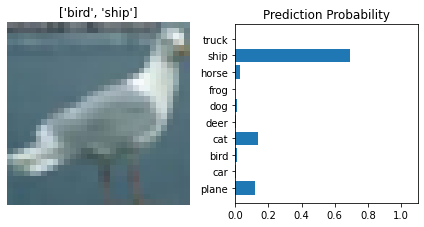

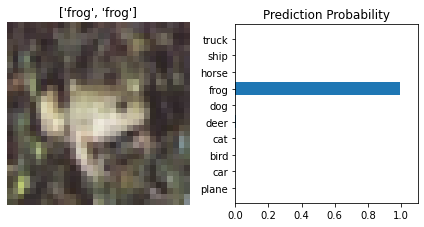

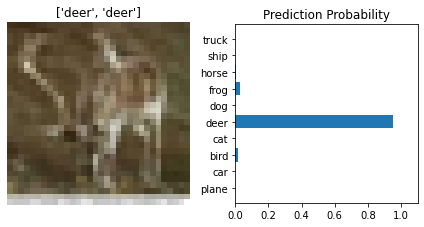

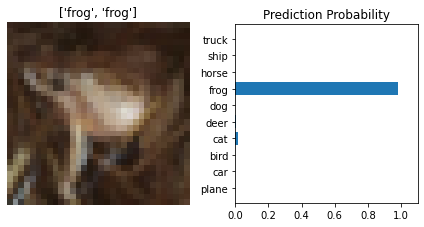

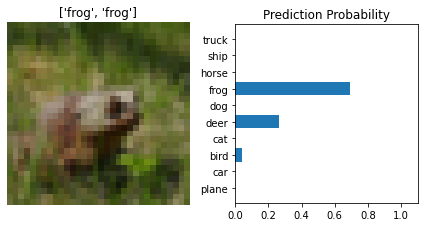

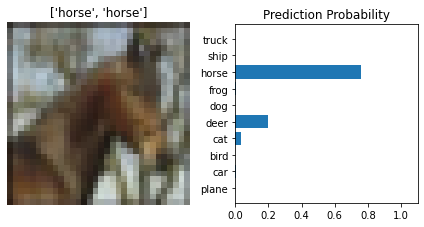

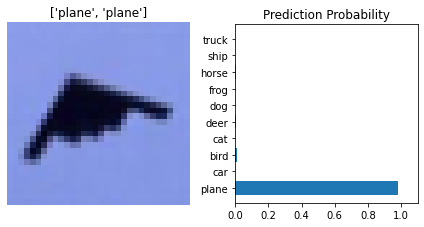

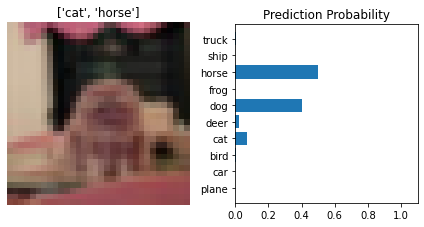

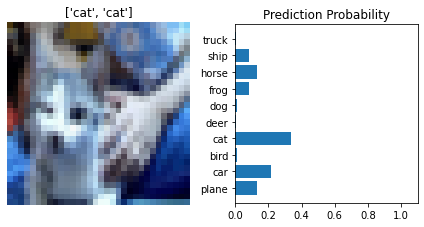

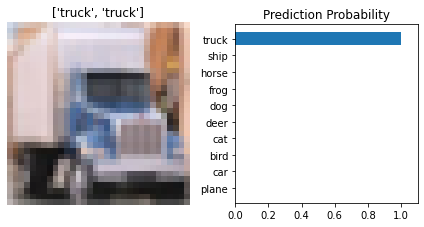

In [16]:
#model_cnn.to('cpu') 
model_cnn.to(device)

# make a batch of predictions
for i in range(10):
    # fetch a batch of test images and predict; note batch contains only 1 image
    image_batch, label_batch = next(iter(test_loader))
    image_batch = image_batch.to(device)
    with torch.no_grad():
        log_pred_prob_batch = model_cnn(image_batch)
    img = image_batch.to('cpu')[0]
    real_label = label_batch[0].item()
    log_pred_prob = log_pred_prob_batch.to('cpu')[0]
    # Output of the network are log-probabilities, need to take exponential for probabilities
    pred_prob = torch.exp(log_pred_prob).data.numpy().squeeze()
    visualize_pred(img, pred_prob, real_label)

# Is the CNN really seeing like we do ?
Adversarial examples using Fast Gradient Sign Method attack
see: https://pytorch.org/tutorials/beginner/fgsm_tutorial.html#fast-gradient-sign-attack


In [17]:
epsilons = [0, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3]
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image using the gradients
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [-1,1] range
    perturbed_image = torch.clamp(perturbed_image, -1, 1)
    # Return the perturbed image
    return perturbed_image

In [29]:
def fgsm_test( model, device, test_loader, epsilon ):
    # Accuracy counter
    correct = 0
    adv_examples = []
    
    model.to(device)
    model.eval() # in train() mode, stuff like dropout and batchnorm behave differently
    
    progress_count = 0;
    # Loop over all examples in test set, one by one (test_loader has batch_size=1)
    for data, target in test_loader:
        progress_count+= 1
        
        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True
        
        # Zero all existing gradients
        model.zero_grad()

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        
        #print(init_pred.shape)
        #print(target.shape)

        # If the model is wrong, then this can't be an adversarial example, move on to the next example
        if init_pred.item() != target.item():
            continue
        
        # Calculate the loss
        loss = F.nll_loss(output, target)
        # Calculate gradients of model in backward pass
        loss.backward()
        # Collect gradients of the data
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)      
        perturbed_data = perturbed_data.to(device)
        
        # Apply the model to the perturbed image
        output = model(perturbed_data)
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        
        # check if the perturbation forces a misclassification
        if final_pred.item() != target.item():
            # Save some adv examples for visualization later
            if len(adv_examples) < 10:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                real_im = data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex, real_im) )
        else:
            correct+= 1
        
        if progress_count % 1000 == 0:
            print('FGSM Attack Iteration: {}'.format(progress_count * len(data)))
            #print(init_pred.cpu().item(), target.cpu().item())

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [30]:
accuracies = [] #list of accuracies
adv_examples = []

# Run test for each epsilon
for eValueError: only one element tensors can be converted to Python scalarsps in epsilons:
    acc, ex = fgsm_test(model_cnn, device, test_loader, eps)
    accuracies.append(acc)
    adv_examples.append(ex)

FGSM Attack Iteration: 1000
FGSM Attack Iteration: 2000
FGSM Attack Iteration: 3000
FGSM Attack Iteration: 4000
FGSM Attack Iteration: 5000
FGSM Attack Iteration: 6000
FGSM Attack Iteration: 7000
FGSM Attack Iteration: 8000
FGSM Attack Iteration: 9000
FGSM Attack Iteration: 10000
Epsilon: 0	Test Accuracy = 7970 / 10000 = 0.797
FGSM Attack Iteration: 1000
FGSM Attack Iteration: 2000
FGSM Attack Iteration: 4000
FGSM Attack Iteration: 5000
FGSM Attack Iteration: 6000
FGSM Attack Iteration: 8000
Epsilon: 0.001	Test Accuracy = 7391 / 10000 = 0.7391
FGSM Attack Iteration: 1000
FGSM Attack Iteration: 2000
FGSM Attack Iteration: 3000
FGSM Attack Iteration: 5000
FGSM Attack Iteration: 6000
FGSM Attack Iteration: 9000
FGSM Attack Iteration: 10000
Epsilon: 0.002	Test Accuracy = 6829 / 10000 = 0.6829
FGSM Attack Iteration: 1000
FGSM Attack Iteration: 2000
FGSM Attack Iteration: 3000
FGSM Attack Iteration: 4000
FGSM Attack Iteration: 6000
FGSM Attack Iteration: 8000
FGSM Attack Iteration: 9000
FGSM

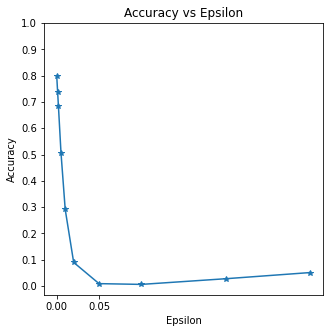

In [31]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(numpy.arange(0, 1.1, step=0.1))
plt.xticks(numpy.arange(0, .1, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<Figure size 576x1440 with 0 Axes>

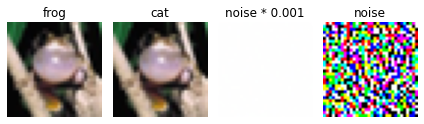

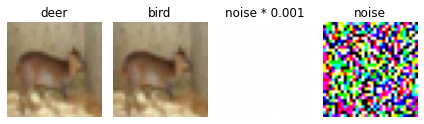

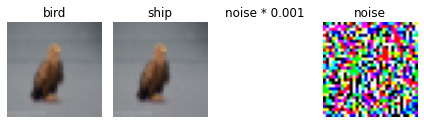

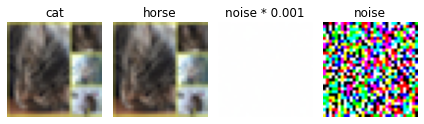

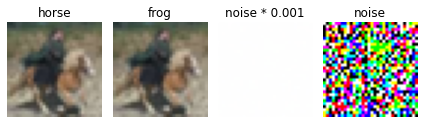

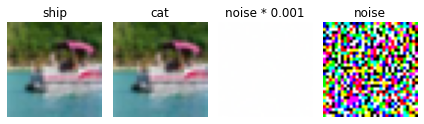

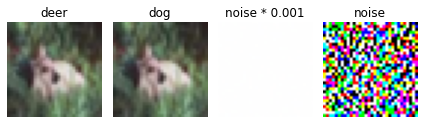

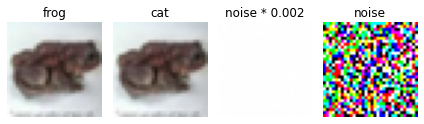

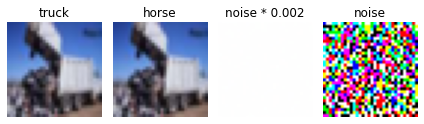

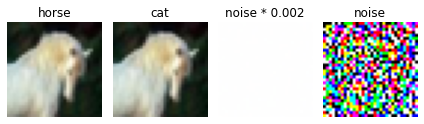

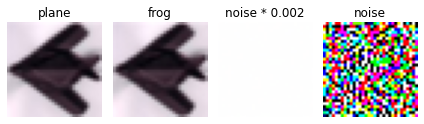

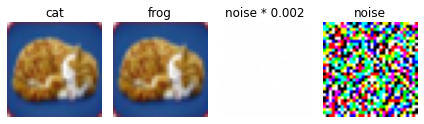

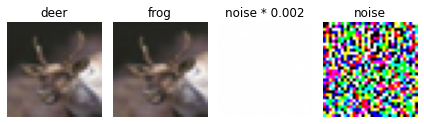

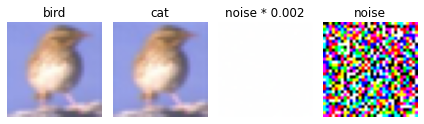

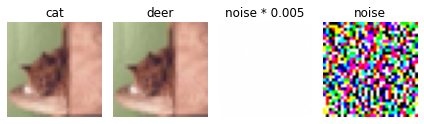

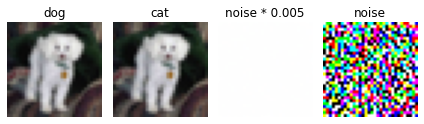

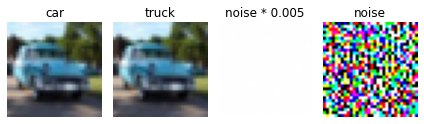

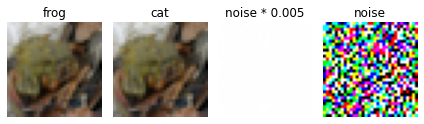

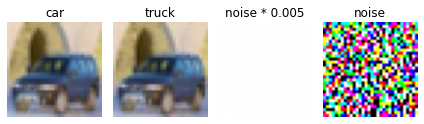

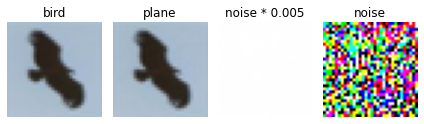

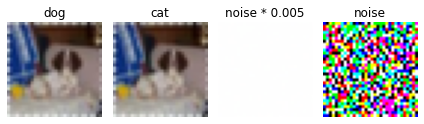

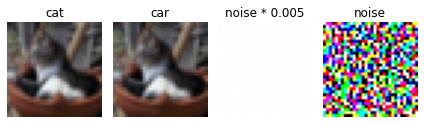

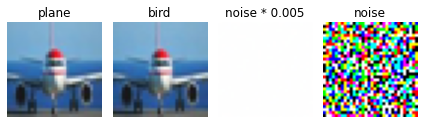

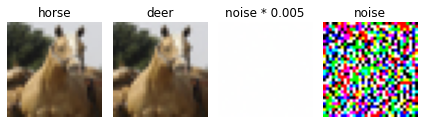

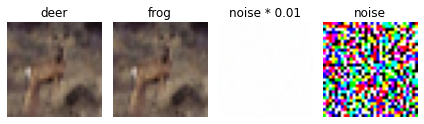

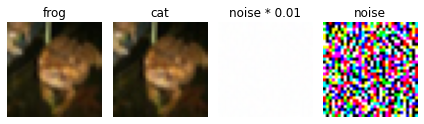

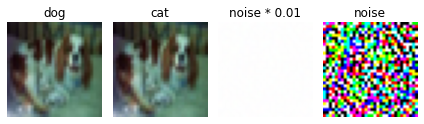

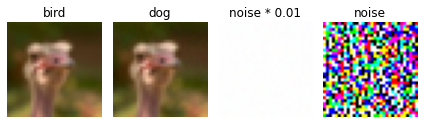

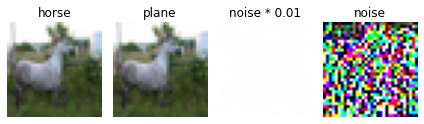

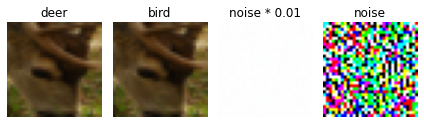

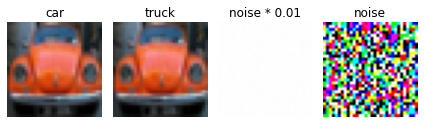

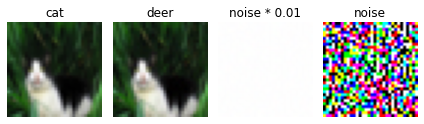

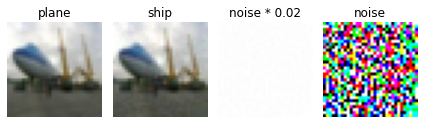

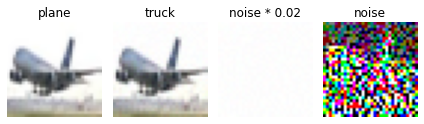

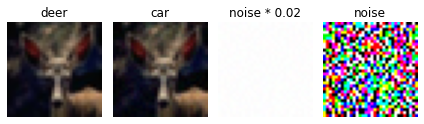

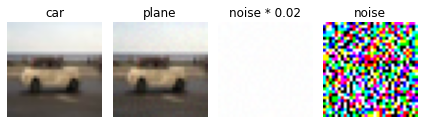

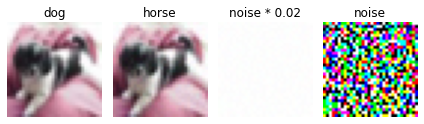

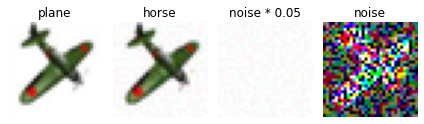

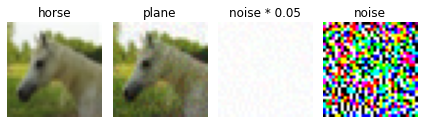

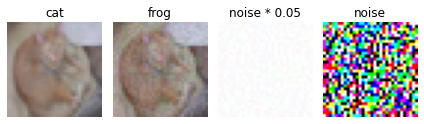

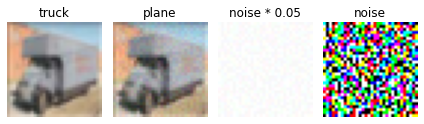

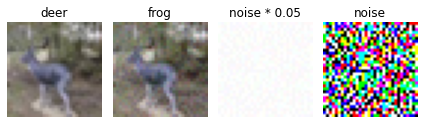

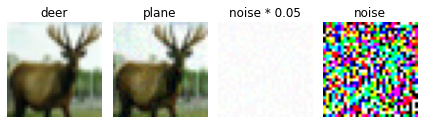

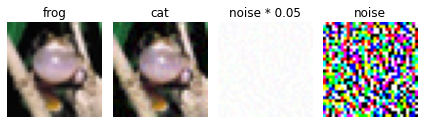

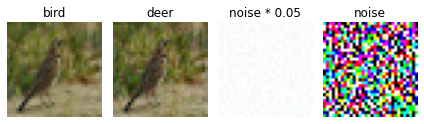

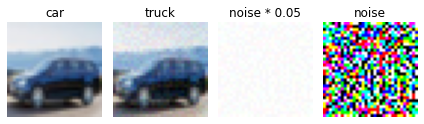

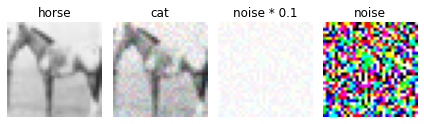

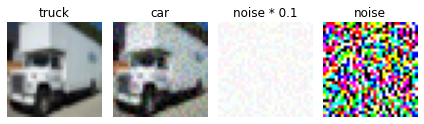

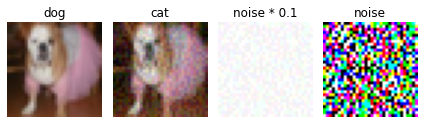

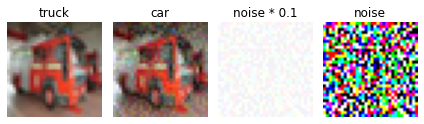

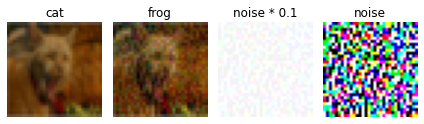

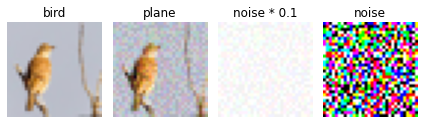

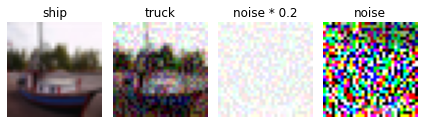

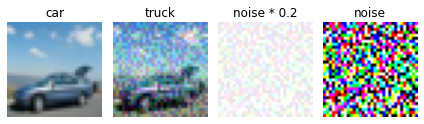

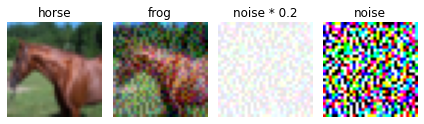

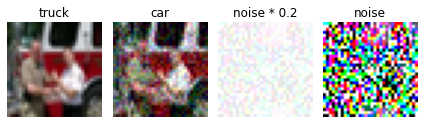

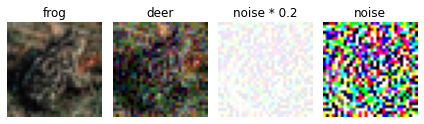

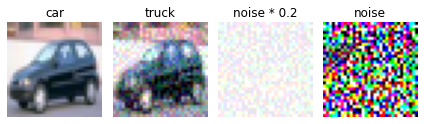

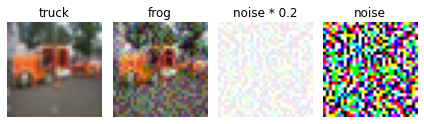

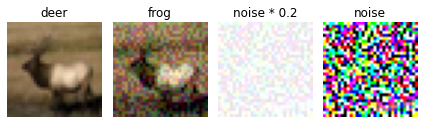

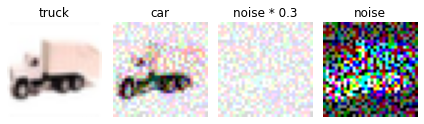

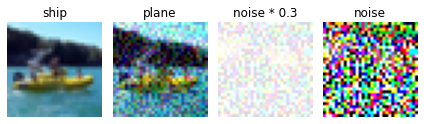

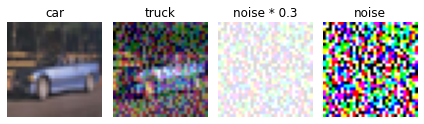

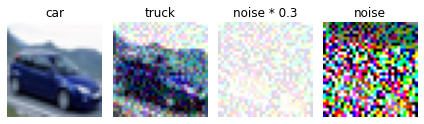

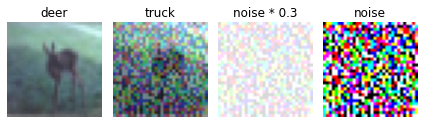

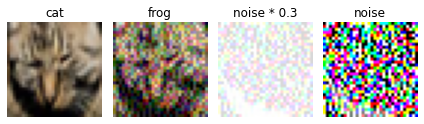

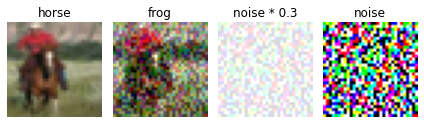

In [32]:
# Plot several examples of adversarial samples at each epsilon
def imshow2(img, plot):
    img = img / 2 + 0.5 # unnormalize
    #npimg = img.numpy()   # convert from tensor
    plot.imshow(numpy.transpose(img, (1, 2, 0)))

plt.figure(figsize=(8,20))
for i in range(len(epsilons)):
    eps = epsilons[i]
    for j in range(len(adv_examples[i])):      
        orig,adv,ex,img = adv_examples[i][j]
        noise = ex - img
        
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(figsize=(6,9), ncols=4)
        
        imshow2(img, ax1)
        ax1.axis('off')
        ax1.set_title(classNames[orig])

        imshow2(ex, ax2)
        ax2.axis('off')
        ax2.set_title(classNames[adv])
        
        imshow2(noise+1, ax3)
        ax3.axis('off')
        ax3.set_title("noise * {}".format(eps))
        
        imshow2(noise/eps, ax4)
        ax4.axis('off')
        ax4.set_title("noise")
        
        plt.tight_layout()